# **ML Lab**

This notebook is developed for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# **(d) Extrapolation capability**

### **Table of Contents**

1\) Split datasets for low and high metamaterial volume fraction

2\) Train MLP model with low volume fraction dataset

3\) Test model performance on high volume fraction dataset

4\) Test model performance on another extrapolation dataset, with different cell parameter range

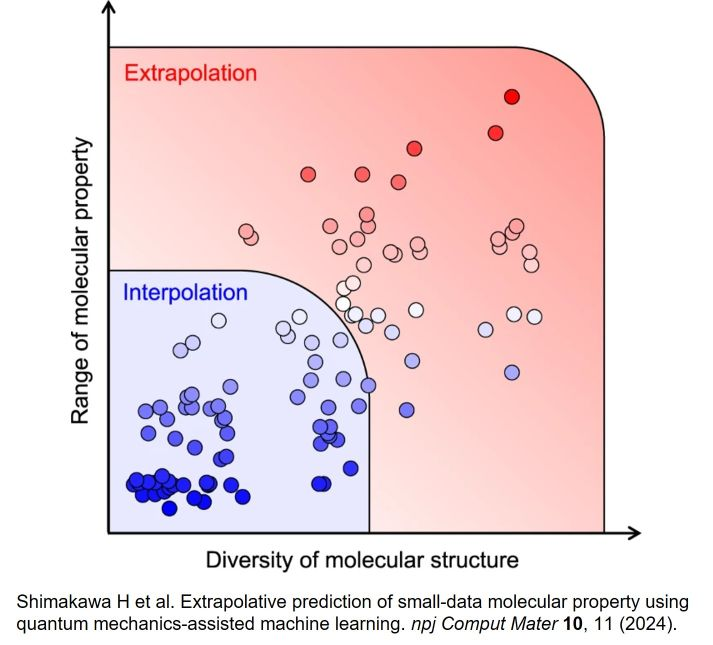

--------------

### Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [ ]:
# --- Clone repository from Git
!git clone https://github.com/IDEA-lab-IC/Tutorials.git
%cd Tutorials

# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from homogenise2D import generate_BCC_unitcell
from MLPpackage import *
from MLPextention import *

Cloning into 'MLLab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.07 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/MLLab


-----------

<h3><font color="lightblue">Load dataset</font></h3>


In [ ]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_1000.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, in_dim  = prop.shape
_, out_dim = param.shape

# **1) Split dataset for conventional training and extrapolation test**
Split dataset to `DatasetI` and `DatasetII` based on volume fraction of metamaterial unit cell. <br>
- Use `DatasetI` (low volume fraction dataset) for conventional training/validation/testing. <br>
- Then use `DatasetII` (high volume fraction dataset) to test extrapolation ability.

In [ ]:
vol = prop[:, 6]  # Extract the volume fraction (7th column, index 6)
idx = np.argsort(vol); prop_s, param_s, vol_s = prop[idx], param[idx], vol[idx] # Sort samples by volume fraction
mid = len(vol_s) // 2 # Split by volume fraction into main half and extrapolation half
prop_main, prop_extrap  = prop_s[:mid],  prop_s[mid:]
param_main, param_extrap = param_s[:mid], param_s[mid:]

print(f"Main:          {prop_main.shape[0]} samples, vf ∈ [{vol_s[:mid].min():.3f}, {vol_s[:mid].max():.3f}]\n"
      f"Extrapolation: {prop_extrap.shape[0]} samples, vf ∈ [{vol_s[mid:].min():.3f}, {vol_s[mid:].max():.3f}]")

Main:          750 samples, vf ∈ [0.020, 0.277]
Extrapolation: 750 samples, vf ∈ [0.278, 0.628]


We visualise the sorted volume fractions as a scatter plot and draw a vertical dashed line at the split index, so we can clearly see how the dataset is divided into the "low volume fraction" and “high volume fraction” regions.

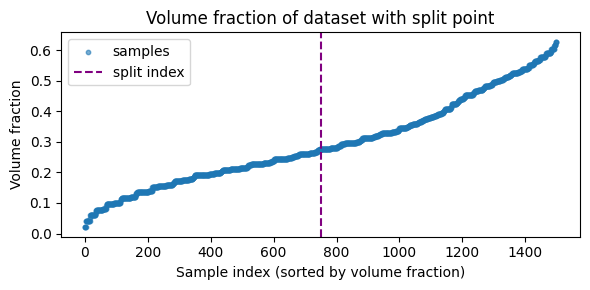

In [ ]:
plot_vf_split(vol_s, mid)

# **2) Train MLP model using `DatasetI`**

<font color="lightblue">Preprocess the dataset</font>

In [ ]:
# --- Split dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test = split_prop_param(
    prop, param, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=False)

In [ ]:
# --- Scale dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test, in_scaler, out_scaler = scale_datasets(
    prop_train, prop_val, prop_test, param_train, param_val, param_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=False)

In [ ]:
# --- Convert to Torch tensors
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(
    lambda a: torch.from_numpy(a).float(),
    (prop_train, param_train, prop_val, param_val, prop_test, param_test))

In [ ]:
# --- Data loader
BATCH_SIZE = 256 # number of samples per mini-batch

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=BATCH_SIZE, shuffle=False)

Conventional procedure for model training using `DatasetI`.

In [ ]:
# --- Define model archietecture
HIDDEN = (8, )         # e.g., (), (64,), (128,64), (256,128,64), ...
DROPOUT = 0.0

model = MLP(in_dim=in_dim, hidden=HIDDEN, out_dim=out_dim, dropout=DROPOUT)

In [ ]:
# --- Train model
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=300, # training epoch
    patience=20, # early stopping if no validation improvement
    criterion=nn.MSELoss(), # Mean Squared Error (MSE) loss for regression
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4), # Adam optimizer – efficient and commonly used
)

=== Training started ===
Epoch   1/300 | Train: 0.275939 | Val: 0.283951
Epoch  20/300 | Train: 0.134914 | Val: 0.133063
Epoch  40/300 | Train: 0.047336 | Val: 0.046831
Epoch  60/300 | Train: 0.012995 | Val: 0.013890
Epoch  80/300 | Train: 0.006767 | Val: 0.007275
Epoch 100/300 | Train: 0.004959 | Val: 0.005223
Epoch 120/300 | Train: 0.003881 | Val: 0.004075
Epoch 140/300 | Train: 0.003096 | Val: 0.003245
Epoch 160/300 | Train: 0.002528 | Val: 0.002550
Epoch 180/300 | Train: 0.002077 | Val: 0.002031
Epoch 200/300 | Train: 0.001749 | Val: 0.001659
Epoch 220/300 | Train: 0.001516 | Val: 0.001407
Epoch 240/300 | Train: 0.001365 | Val: 0.001248
Epoch 260/300 | Train: 0.001276 | Val: 0.001159
Epoch 280/300 | Train: 0.001222 | Val: 0.001103
Epoch 300/300 | Train: 0.001188 | Val: 0.001079
=== Training complete ===


Evaluate the trained MLP model using test dataset from `DatasetI`

=== Test Metrics per Output ===
Output 0: MAE=0.003096, RMSE=0.003624, R^2=0.9952
Output 1: MAE=0.002796, RMSE=0.003208, R^2=0.9965
Output 2: MAE=0.003132, RMSE=0.003704, R^2=0.9950
Output 3: MAE=0.003031, RMSE=0.003506, R^2=0.9959

Overall MAE:  0.003014
Overall RMSE: 0.003510
Mean R^2:     0.9957


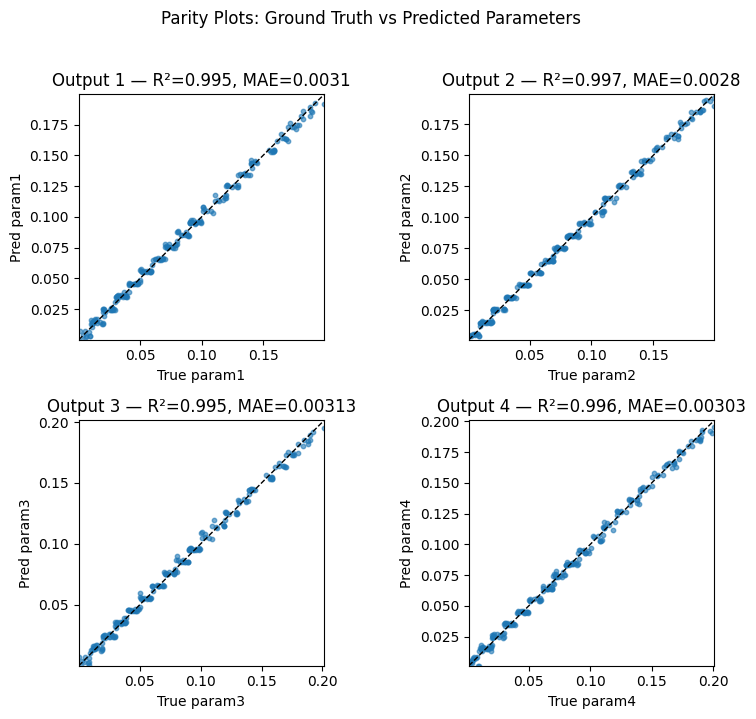

In [ ]:
# --- Evaluate model
y_true_plot, y_pred_plot, mae, rmse, r2 = evaluate_model(
    model, test_loader, out_dim=out_dim, out_scaler=out_scaler, scale_outputs=True, print_summary=True,)
plot_parity_plots(
    y_true_plot=y_true_plot, y_pred_plot=y_pred_plot, mae=mae, r2=r2, out_dim=out_dim,)

# **3) Test the extrapolation capability of MLP model using `DatasetII`**

Use `DatasetII` (high volume fraction dataset) to see model's ability in extrapolation.
- First, preprocess `DatasetII` and prepare the dataloader.
- Then, use the Trained MLP model to output metamaterial cell parameters on `DatasetII`.
- Finally, we compare the MLP’s outputs with the ground-truth values to see how well the model performs on samples outside the training range.
- This highlights a common limitation of standard MLPs: they often fit the training domain well but struggle to extrapolate reliably to unseen regions.

In [ ]:
# ---- Preprocess extrapolation dataset
scale_inputs=True; scale_outputs=True # If you used Scaler on the main splits, apply the SAME scalers here.
prop_extrap_scaled  = in_scaler.transform(prop_extrap) if scale_inputs else prop_extrap
param_extrap_scaled = out_scaler.transform(param_extrap) if scale_outputs else param_extrap

X_extrap = torch.from_numpy(prop_extrap_scaled).float() # Convert to float32 tensors
Y_extrap = torch.from_numpy(param_extrap_scaled).float()
extrap_loader = DataLoader(TensorDataset(X_extrap, Y_extrap), batch_size=256, shuffle=False,)

In [ ]:
# ---- Run the model on extrapolation dataset
y_true_ex_plot, y_pred_ex_plot, mae, rmse, r2 = evaluate_model(
    model, extrap_loader, out_dim=out_dim, out_scaler=out_scaler, scale_outputs=True, print_summary=True,)

=== Test Metrics per Output ===
Output 0: MAE=0.003207, RMSE=0.003855, R^2=0.9937
Output 1: MAE=0.002868, RMSE=0.003316, R^2=0.9953
Output 2: MAE=0.003273, RMSE=0.003867, R^2=0.9937
Output 3: MAE=0.003082, RMSE=0.003655, R^2=0.9943

Overall MAE:  0.003108
Overall RMSE: 0.003673
Mean R^2:     0.9943


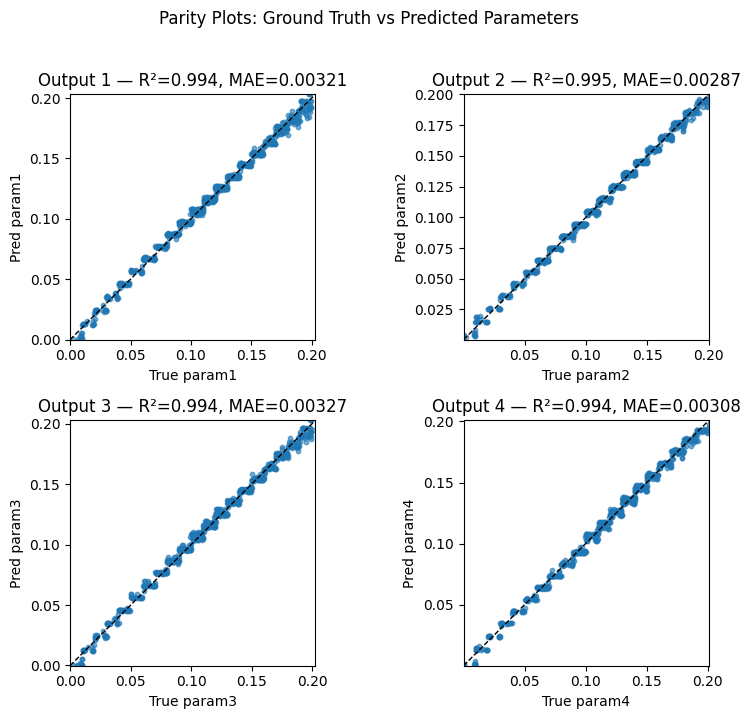

In [ ]:
# ---- Compare model outputs with ground-truth values
plot_parity_plots(
    y_true_plot=y_true_ex_plot, y_pred_plot=y_pred_ex_plot, mae=mae, r2=r2, out_dim=out_dim,)

It is observed that the MLP inverse generator achieves similarly high performance in both interpolation and extrapolation tests (`DatasetI` and `DatasetII` tests), demonstrating that **the model generalises well to high volume fraction cell properties not included in the training dataset**.

# **4) Test the extrapolation capability of MLP model using `DatasetIII`**

Load another test dataset as `DatasetIII`, which has cell parameters ranging from 0.20 to 0.25, different from the previous loaded dataset (`DatasetI` and `DatasetII`) where cell parameters are between 0.01 to 0.20.

Preprocess the `DataIII` and use it to test the trained MLP model.

In [ ]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_500_extrapolation.npz")
prop_extra  = data["prop"]    # input features
param_extra = data["param"]   # target outputs

In [ ]:
# ---- Preprocess extrapolation dataset
scale_inputs=True; scale_outputs=True # If you used Scaler on the main splits, apply the SAME scalers here.
prop_extrap_scaled  = in_scaler.transform(prop_extrap) if scale_inputs else prop_extrap
param_extrap_scaled = out_scaler.transform(param_extrap) if scale_outputs else param_extrap

X_extrap = torch.from_numpy(prop_extrap_scaled).float() # Convert to float32 tensors
Y_extrap = torch.from_numpy(param_extrap_scaled).float()
extrap_loader = DataLoader(TensorDataset(X_extrap, Y_extrap), batch_size=256, shuffle=False,)

In [ ]:
# ---- Run the model on extrapolation dataset
y_true_ex_plot, y_pred_ex_plot, mae, rmse, r2 = evaluate_model(
    model, extrap_loader, out_dim=out_dim, out_scaler=out_scaler, scale_outputs=True, print_summary=True,)

=== Test Metrics per Output ===
Output 0: MAE=0.003207, RMSE=0.003855, R^2=0.9937
Output 1: MAE=0.002868, RMSE=0.003316, R^2=0.9953
Output 2: MAE=0.003273, RMSE=0.003867, R^2=0.9937
Output 3: MAE=0.003082, RMSE=0.003655, R^2=0.9943

Overall MAE:  0.003108
Overall RMSE: 0.003673
Mean R^2:     0.9943


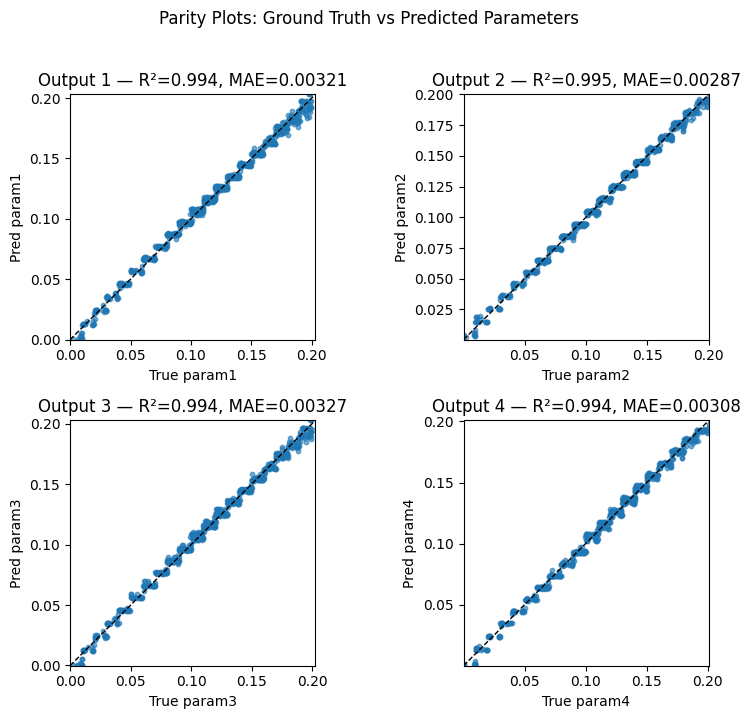

In [ ]:
# ---- Compare model outputs with ground-truth values
plot_parity_plots(
    y_true_plot=y_true_ex_plot, y_pred_plot=y_pred_ex_plot, mae=mae, r2=r2, out_dim=out_dim,)

It is observed that the MLP inverse generator also achieves similarly high performance on `DatasetIII` where cell parameters lie outside the training range, indicating that **the model generalises well beyond the parameter space seen during training**.

### Interpolation vs Extrapolation Performance

This good **extrapolation behaviour** is *not solely a consequence of the model architecture*, but is strongly influenced by the **nature of the dataset**. In this problem, the relationship between **metamaterial unit cell parameters** and the corresponding **effective properties** is governed by **physical laws**. Within a **physically meaningful parameter range**, this mapping is **smooth, continuous, and constrained**, rather than arbitrary. As a result, extending predictions to **unseen but physically admissible parameter values** amounts to extrapolating the **same underlying physical relationship**.

From a **modelling perspective**, although neural networks are often described as *interpolation-based methods*, they can **generalise beyond the training range** when the underlying **input-output relationship** is *smooth, low-dimensional, and sufficiently well sampled*. In such cases, extrapolation does *not require the model to invent new behaviour*, but rather to **extend trends already learned from the data**.

It is important to emphasise that **such good extrapolation performance should not be expected in general**. The ability of ML models to extrapolate is **highly problem-dependent** and can degrade rapidly in the presence of **sharp transitions, regime changes, strong nonlinearities, or insufficient data coverage**. In this case, **reliable extrapolation is possible** because the **underlying physical mechanisms remain valid** across the explored parameter range.
